=== INPUTS ===
Locations: ['Warehouse', 'C1', 'C2', 'C3']
Parcels: {'C1': {'value': 50, 'time': (9, 12), 'weight': 10}, 'C2': {'value': 60, 'time': (10, 13), 'weight': 20}, 'C3': {'value': 40, 'time': (11, 14), 'weight': 15}}
Vehicle capacity: 30

=== UNIT 1: Recurrence-based minimal remaining cost (TSP-style, no return) ===
Recurrence minimal cost to visit all customers (not adding return-to-base): 12
(Note: recurrence function returns minimal travel to visit remaining nodes in some order.)

=== UNIT 2: Greedy & Knapsack ===
Greedy by value/weight selected customers: ['C1', 'C2']
0/1 Knapsack optimal selection under capacity: ['C1', 'C2'] total value: 110
Time-windows feasibility for knapsack selection?
 Feasible: False
 Knapsack selection violates time windows (no feasible route found).

Try greedy selection instead:
 Feasible: False

=== UNIT 3: Graph Algorithms (Dijkstra & Prim) ===
Dijkstra distances from Warehouse: {'Warehouse': 0, 'C1': 4, 'C2': 8, 'C3': 6}
Prim MST edges (u, v,

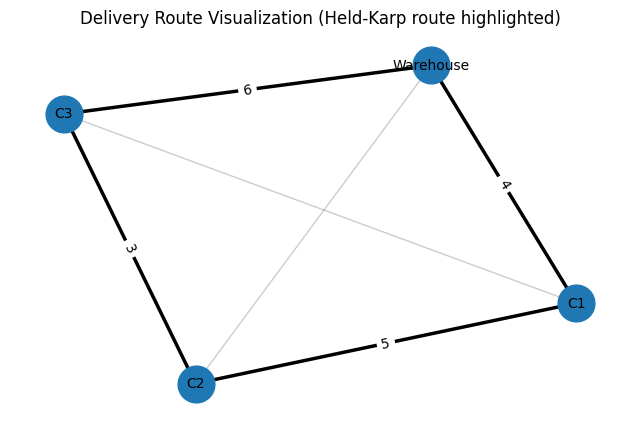

=== FINAL SUMMARY ===
knapsack_selection : ['C1', 'C2']
knapsack_value : 110
greedy_selection : ['C1', 'C2']
recurrence_cost_no_return : 12
dijkstra_from_warehouse : {'Warehouse': 0, 'C1': 4, 'C2': 8, 'C3': 6}
mst_edges : [('Warehouse', 'C1', 4), ('C1', 'C2', 5), ('C2', 'C3', 3)]
tsp_bruteforce_route : ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse']
tsp_bruteforce_cost : 18
held_karp_route : ['Warehouse', 'C3', 'C2', 'C1', 'Warehouse']
held_karp_cost : 18


In [2]:


import itertools
import heapq
import math
import networkx as nx
import matplotlib.pyplot as plt
from functools import lru_cache


locations = ['Warehouse', 'C1', 'C2', 'C3']

distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]

parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}

vehicle_capacity = 30
warehouse_index = 0
start_time = 9


loc_index = {name: i for i, name in enumerate(locations)}
customer_indices = [loc_index[c] for c in locations if c != 'Warehouse']


def travel_time(i, j):
    return distance_matrix[i][j]


@lru_cache(maxsize=None)
def recurrence_delivery_cost(curr_idx, visited_mask):
    """
    Returns minimal remaining travel distance starting from curr_idx,
    visiting all customers represented by bits in visited_mask (1 means remaining to visit).
    visited_mask uses bits for customers indices mapped to positions 0..m-1
    where order of customers is customer_indices.
    """

    if visited_mask == 0:
        return 0

    best = float('inf')

    m = len(customer_indices)
    for bit in range(m):
        if visited_mask & (1 << bit):
            next_idx = customer_indices[bit]
            cost_to_next = travel_time(curr_idx, next_idx)
            rest_mask = visited_mask & ~(1 << bit)
            total = cost_to_next + recurrence_delivery_cost(next_idx, rest_mask)
            if total < best:
                best = total
    return best


def recurrence_total_cost_all_customers(return_to_base=False):
    m = len(customer_indices)
    full_mask = (1 << m) - 1
    base_cost = recurrence_delivery_cost(warehouse_index, full_mask)
    if return_to_base:

        best = float('inf')
        for bit in range(m):
            last = customer_indices[bit]

            pass
    return base_cost



def greedy_by_ratio(parcels, capacity):
    items = []
    for loc, info in parcels.items():
        ratio = info['value'] / info['weight']
        items.append((ratio, loc, info))
    items.sort(reverse=True, key=lambda x: x[0])
    selected = []
    remain = capacity
    for ratio, loc, info in items:
        if info['weight'] <= remain:
            selected.append(loc)
            remain -= info['weight']
    return selected


def knapsack_01(parcels, capacity):
    keys = list(parcels.keys())
    n = len(keys)
    W = capacity

    dp = [[0]*(W+1) for _ in range(n+1)]
    for i in range(1, n+1):
        k = keys[i-1]
        wt = parcels[k]['weight']
        val = parcels[k]['value']
        for w in range(W+1):
            dp[i][w] = dp[i-1][w]
            if wt <= w:
                dp[i][w] = max(dp[i][w], dp[i-1][w-wt] + val)

    w = W
    chosen = []
    for i in range(n, 0, -1):
        if dp[i][w] != dp[i-1][w]:
            k = keys[i-1]
            chosen.append(k)
            w -= parcels[k]['weight']
    chosen.reverse()
    return chosen, dp[n][W]



def time_windows_feasible(selected_customers, start_time=start_time):
    """
    selected_customers: list of customer names (e.g., ['C1','C3'])
    Returns:
        - feasible: bool
        - best_route: list of locations indices starting from warehouse and visiting all selected customers and optionally returning (we provide route to visit them once)
        - arrival_times: arrival times at each visited node (excluding warehouse start)
        - total_travel_distance: sum of travel distances along chosen route (not including return to base)
    Approach:
      Bitmask DP: dp[mask][j] = earliest arrival time at customer j (index in selected_customers)
      j is the index within selected_customers list.
      Start from warehouse at start_time.
    """
    if not selected_customers:
        return True, [warehouse_index], [], 0


    sel_indices = [loc_index[c] for c in selected_customers]
    m = len(sel_indices)
    INF = float('inf')

    dp = [[INF]*m for _ in range(1<<m)]
    parent = [[None]*m for _ in range(1<<m)]


    for j in range(m):
        idx_j = sel_indices[j]
        arrive = start_time + travel_time(warehouse_index, idx_j)
        earliest, latest = parcels[selected_customers[j]]['time']

        if arrive <= latest:
            dp[1<<j][j] = max(arrive, earliest)
            parent[1<<j][j] = (None, None)


    for mask in range(1<<m):
        for j in range(m):
            if not (mask & (1<<j)): continue
            t_j = dp[mask][j]
            if t_j == INF: continue

            for k in range(m):
                if mask & (1<<k): continue
                idx_j = sel_indices[j]
                idx_k = sel_indices[k]
                travel = travel_time(idx_j, idx_k)
                arrive_k = t_j + travel
                earliest_k, latest_k = parcels[selected_customers[k]]['time']
                if arrive_k <= latest_k:
                    finish_k = max(arrive_k, earliest_k)  # wait if early
                    new_mask = mask | (1<<k)
                    if finish_k < dp[new_mask][k]:
                        dp[new_mask][k] = finish_k
                        parent[new_mask][k] = (mask, j)

    full_mask = (1<<m) - 1

    best_end = None
    best_time = INF
    for j in range(m):
        if dp[full_mask][j] < best_time:
            best_time = dp[full_mask][j]
            best_end = j
    if best_end is None:
        return False, None, None, None


    route_indices = []
    arrival_times = []
    mask = full_mask
    j = best_end
    while j is not None:
        route_indices.append(sel_indices[j])
        arrival_times.append(dp[mask][j])
        prev = parent[mask][j]
        if prev is None or prev[0] is None:
            break
        mask, j = prev

    route_indices.reverse()
    arrival_times.reverse()
    route = [warehouse_index] + route_indices

    total_dist = 0
    for a, b in zip(route[:-1], route[1:]):
        total_dist += travel_time(a, b)
    return True, route, arrival_times, total_dist



def dijkstra(start_idx):
    n = len(locations)
    dist = [math.inf]*n
    prev = [None]*n
    dist[start_idx] = 0
    pq = [(0, start_idx)]
    while pq:
        d,u = heapq.heappop(pq)
        if d > dist[u]: continue
        for v in range(n):
            if v==u: continue
            w = travel_time(u,v)
            nd = d + w
            if nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(pq, (nd,v))
    return dist, prev

def prim_mst():
    n = len(locations)
    in_mst = [False]*n
    key = [math.inf]*n
    parent = [-1]*n
    key[0] = 0
    for _ in range(n):

        u = min((key[i], i) for i in range(n) if not in_mst[i])[1]
        in_mst[u] = True
        for v in range(n):
            if in_mst[v] or v==u: continue
            w = travel_time(u,v)
            if w < key[v]:
                key[v] = w
                parent[v] = u

    edges = []
    total_weight = 0
    for v in range(1, n):
        edges.append((parent[v], v, travel_time(parent[v], v)))
        total_weight += travel_time(parent[v], v)
    return edges, total_weight


def tsp_brute_force(locations, distance_matrix):
    n = len(locations)
    indices = list(range(1, n))
    min_cost = float('inf')
    best_route = None
    for perm in itertools.permutations(indices):
        cost = 0
        cost += distance_matrix[0][perm[0]]
        for i in range(len(perm)-1):
            cost += distance_matrix[perm[i]][perm[i+1]]
        cost += distance_matrix[perm[-1]][0]
        if cost < min_cost:
            min_cost = cost
            best_route = (0,) + perm + (0,)
    route_names = [locations[i] for i in best_route]
    return route_names, min_cost

def held_karp(distance_matrix):
    """
    Held-Karp DP to compute optimal TSP tour cost (returns to start).
    Returns (min_cost, path_indices)
    Only use for small n (n <= ~12).
    """
    n = len(distance_matrix)

    m = n
    size = 1 << (m-1)
    INF = float('inf')
    DP = [ [INF]*m for _ in range(1<< (m-1)) ]
    parent = [ [None]*m for _ in range(1<< (m-1)) ]

    for j in range(1, m):
        mask = 1 << (j-1)
        DP[mask][j] = distance_matrix[0][j]
        parent[mask][j] = 0

    for mask in range(size):
        for j in range(1, m):
            if not (mask & (1 << (j-1))): continue
            for k in range(1, m):
                if mask & (1 << (k-1)): continue
                new_mask = mask | (1 << (k-1))
                new_cost = DP[mask][j] + distance_matrix[j][k]
                if new_cost < DP[new_mask][k]:
                    DP[new_mask][k] = new_cost
                    parent[new_mask][k] = j
    full_mask = (1 << (m-1)) - 1
    best = INF
    last = None
    for j in range(1, m):
        cost = DP[full_mask][j] + distance_matrix[j][0]
        if cost < best:
            best = cost
            last = j

    path = [0]
    mask = full_mask
    cur = last
    stack = []
    while cur and cur is not None:
        stack.append(cur)
        prev = parent[mask][cur]
        mask = mask & ~(1 << (cur-1))
        cur = prev
        if cur == 0:
            break

    stack.reverse()
    path.extend(stack)
    path.append(0)
    return best, path


print("=== INPUTS ===")
print("Locations:", locations)
print("Parcels:", parcels)
print("Vehicle capacity:", vehicle_capacity)
print()


print("=== UNIT 1: Recurrence-based minimal remaining cost (TSP-style, no return) ===")
m = len(customer_indices)
full_mask = (1 << m) - 1
rec_cost_no_return = recurrence_delivery_cost(warehouse_index, full_mask)
print(f"Recurrence minimal cost to visit all customers (not adding return-to-base): {rec_cost_no_return}")
print("(Note: recurrence function returns minimal travel to visit remaining nodes in some order.)")
print()


print("=== UNIT 2: Greedy & Knapsack ===")
greedy_sel = greedy_by_ratio(parcels, vehicle_capacity)
print("Greedy by value/weight selected customers:", greedy_sel)

knap_sel, knap_value = knapsack_01(parcels, vehicle_capacity)
print("0/1 Knapsack optimal selection under capacity:", knap_sel, "total value:", knap_value)


feasible, route, arrivals, dist = time_windows_feasible(knap_sel, start_time=start_time)
print("Time-windows feasibility for knapsack selection?")
print(" Feasible:", feasible)
if feasible:
    route_names = [locations[i] for i in route]
    print(" Route (warehouse -> customers):", route_names)
    print(" Arrival times at customers:", arrivals)
    print(" Total distance along route (no return):", dist)
else:
    print(" Knapsack selection violates time windows (no feasible route found).")
print()


if not feasible and greedy_sel:
    feasible_g, route_g, arr_g, dist_g = time_windows_feasible(greedy_sel, start_time=start_time)
    print("Try greedy selection instead:")
    print(" Feasible:", feasible_g)
    if feasible_g:
        print(" Route:", [locations[i] for i in route_g])
        print(" Arrivals:", arr_g)
print()


print("=== UNIT 3: Graph Algorithms (Dijkstra & Prim) ===")
distances_from_warehouse, _ = dijkstra(warehouse_index)
print("Dijkstra distances from Warehouse:", {locations[i]: distances_from_warehouse[i] for i in range(len(locations))})

mst_edges, mst_weight = prim_mst()
print("Prim MST edges (u, v, w):", [(locations[u], locations[v], w) for (u,v,w) in mst_edges])
print("MST total weight:", mst_weight)
print()


print("=== UNIT 4: TSP Solutions ===")
route_bf, cost_bf = tsp_brute_force(locations, distance_matrix)
print("TSP brute-force optimal route:", route_bf)
print("TSP brute-force total distance:", cost_bf)


hk_cost, hk_path = held_karp(distance_matrix)
hk_route_names = [locations[i] for i in hk_path]
print("Held-Karp TSP cost:", hk_cost)
print("Held-Karp route (indices):", hk_path)
print("Held-Karp route (names):", hk_route_names)
print()


def plot_route(route_indices):
    G = nx.Graph()
    n = len(locations)
    for i in range(n):
        G.add_node(i, label=locations[i])

    for i in range(n):
        for j in range(i+1, n):
            G.add_edge(i, j, weight=distance_matrix[i][j])
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8,5))

    nx.draw_networkx_nodes(G, pos, node_size=700)
    labels = {i: locations[i] for i in range(len(locations))}
    nx.draw_networkx_labels(G, pos, labels, font_size=10)

    nx.draw_networkx_edges(G, pos, alpha=0.2)

    route_edges = [(route_indices[i], route_indices[i+1]) for i in range(len(route_indices)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=route_edges, width=2.5)

    edge_labels = {(u,v): distance_matrix[u][v] for (u,v) in route_edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Delivery Route Visualization (Held-Karp route highlighted)")
    plt.axis('off')
    plt.show()

print("Plotting Held-Karp route...")
plot_route(hk_path)


final = {
    'knapsack_selection': knap_sel,
    'knapsack_value': knap_value,
    'greedy_selection': greedy_sel,
    'recurrence_cost_no_return': rec_cost_no_return,
    'dijkstra_from_warehouse': {locations[i]: distances_from_warehouse[i] for i in range(len(locations))},
    'mst_edges': [(locations[u], locations[v], w) for (u,v,w) in mst_edges],
    'tsp_bruteforce_route': route_bf,
    'tsp_bruteforce_cost': cost_bf,
    'held_karp_route': hk_route_names,
    'held_karp_cost': hk_cost
}

print("=== FINAL SUMMARY ===")
for k,v in final.items():
    print(k, ":", v)


In [3]:
!pip install memory_profiler matplotlib networkx


In [4]:
import time
from memory_profiler import memory_usage
from itertools import permutations
import numpy as np

def tsp_bruteforce(distance_matrix):
    n = len(distance_matrix)
    nodes = list(range(1, n))  # customers only

    min_cost = float('inf')
    best_route = None

    for perm in permutations(nodes):
        cost = distance_matrix[0][perm[0]]
        for i in range(len(perm)-1):
            cost += distance_matrix[perm[i]][perm[i+1]]
        cost += distance_matrix[perm[-1]][0]

        if cost < min_cost:
            min_cost = cost
            best_route = (0,) + perm + (0,)

    return best_route, min_cost

def benchmark_tsp(n):
    # generate random distance matrix
    matrix = np.random.randint(2, 15, size=(n, n))
    np.fill_diagonal(matrix, 0)

    start = time.time()
    mem = memory_usage((tsp_bruteforce, (matrix,)), max_iterations=1)
    duration = time.time() - start

    return duration, max(mem) - min(mem)

sizes = [3,4,5,6]
tsp_times = []
tsp_memory = []

for n in sizes:
    t, m = benchmark_tsp(n)
    tsp_times.append(t)
    tsp_memory.append(m)
    print(f"{n} nodes → time: {t:.4f}s | memory: {m:.4f} MiB")


3 nodes → time: 0.0156s | memory: 0.1133 MiB
4 nodes → time: 0.0188s | memory: 0.0000 MiB
5 nodes → time: 0.0209s | memory: 0.0000 MiB
6 nodes → time: 0.0150s | memory: 0.0000 MiB


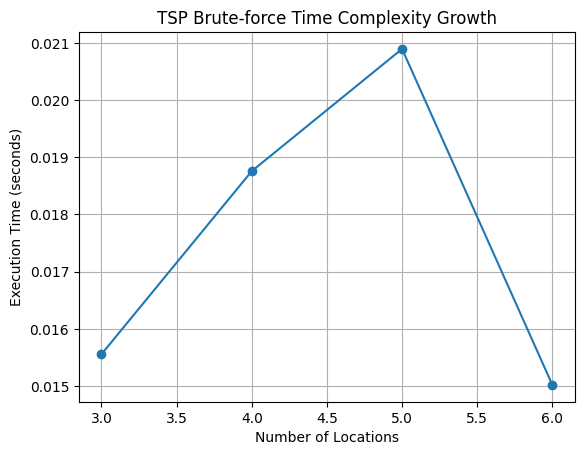

In [5]:
import matplotlib.pyplot as plt

plt.plot(sizes, tsp_times, marker='o')
plt.xlabel("Number of Locations")
plt.ylabel("Execution Time (seconds)")
plt.title("TSP Brute-force Time Complexity Growth")
plt.grid(True)
plt.show()


In [6]:
def dp_time_window(parcels):
    # Sort by latest delivery
    items = sorted(parcels.items(), key=lambda x: x[1]['time'][1])
    n = len(items)

    dp = [0] * (n+1)

    for i in range(1, n+1):
        value = items[i-1][1]['value']
        start_i, end_i = items[i-1][1]['time']

        include = value
        for j in range(i-1, 0, -1):
            prev_start, prev_end = items[j-1][1]['time']
            if prev_end <= start_i:  # non-overlapping time windows
                include += dp[j]
                break

        dp[i] = max(dp[i-1], include)

    return dp[-1]

def benchmark_dp(k):
    import random
    parcels = {
        f'C{i}': {
            'value': random.randint(10, 80),
            'time': (8+i, 10+i),
            'weight': random.randint(5, 20),
        } for i in range(k)
    }

    start = time.time()
    mem = memory_usage((dp_time_window, (parcels,)), max_iterations=1)
    duration = time.time() - start
    return duration, max(mem)-min(mem)

dp_sizes = [5,10,15,20,25]
dp_times = []
dp_memory = []

for k in dp_sizes:
    t,m = benchmark_dp(k)
    dp_times.append(t)
    dp_memory.append(m)
    print(f"{k} parcels → DP time: {t:.4f}s | memory: {m:.4f} MiB")


5 parcels → DP time: 0.0170s | memory: 0.0000 MiB
10 parcels → DP time: 0.0212s | memory: 0.0000 MiB
15 parcels → DP time: 0.0204s | memory: 0.0000 MiB
20 parcels → DP time: 0.0206s | memory: 0.0000 MiB
25 parcels → DP time: 0.0224s | memory: 0.0000 MiB


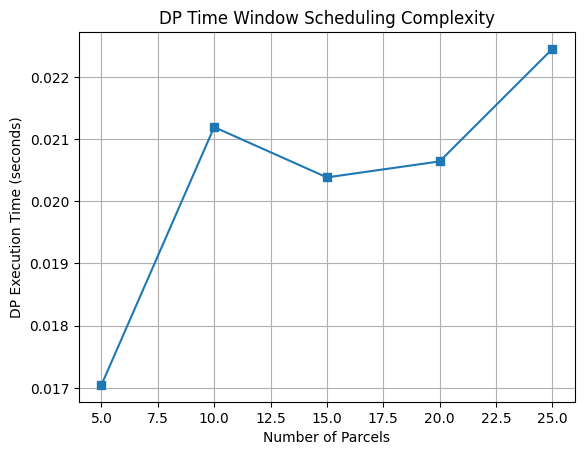

In [7]:
plt.plot(dp_sizes, dp_times, marker='s')
plt.xlabel("Number of Parcels")
plt.ylabel("DP Execution Time (seconds)")
plt.title("DP Time Window Scheduling Complexity")
plt.grid(True)
plt.show()


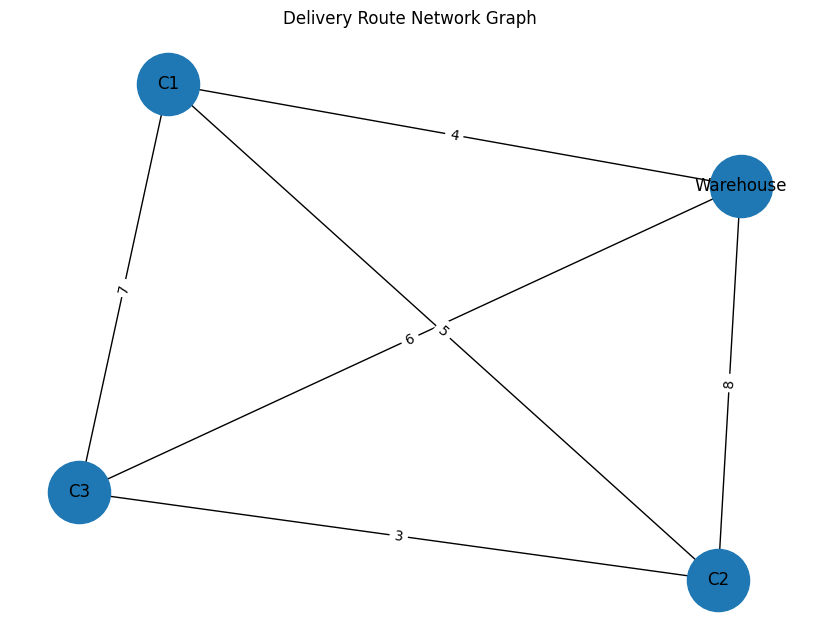

In [8]:
import networkx as nx

locations = ['Warehouse','C1','C2','C3']
distance_matrix = [
    [0,4,8,6],
    [4,0,5,7],
    [8,5,0,3],
    [6,7,3,0]
]

G = nx.Graph()

# Add nodes
for loc in locations:
    G.add_node(loc)

# Add edges based on matrix
for i in range(len(locations)):
    for j in range(i+1, len(locations)):
        G.add_edge(locations[i], locations[j],
                   weight=distance_matrix[i][j])

pos = nx.spring_layout(G)
edges = G.edges()

# plot graph
plt.figure(figsize=(8,6))
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=12)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Delivery Route Network Graph")
plt.show()


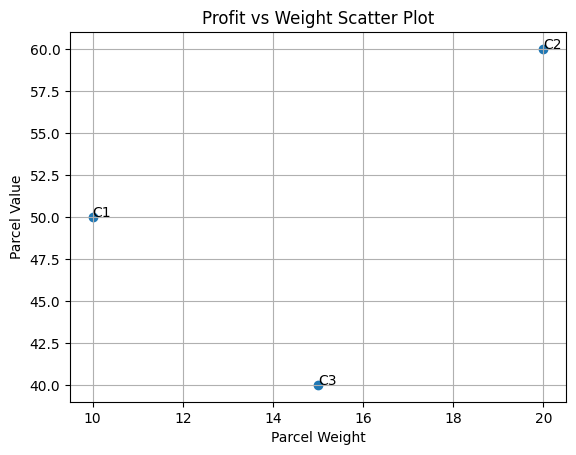

In [9]:
parcel_weights = [10,20,15]
parcel_values = [50,60,40]
customers = ['C1','C2','C3']

plt.scatter(parcel_weights, parcel_values)
for i, c in enumerate(customers):
    plt.annotate(c, (parcel_weights[i], parcel_values[i]))

plt.xlabel("Parcel Weight")
plt.ylabel("Parcel Value")
plt.title("Profit vs Weight Scatter Plot")
plt.grid(True)
plt.show()


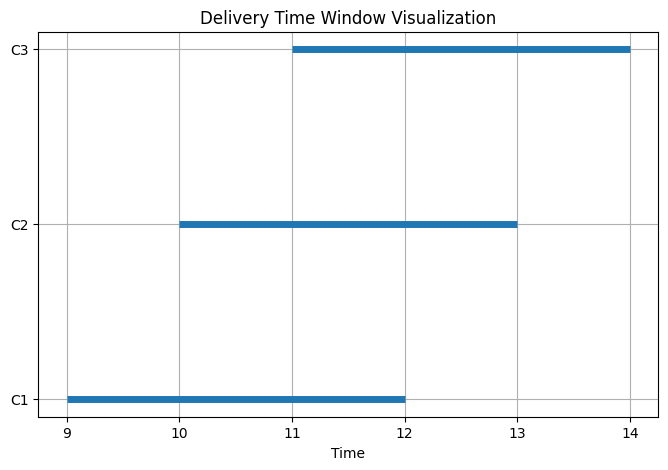

In [10]:
import numpy as np

customers = ["C1","C2","C3"]
time_windows = [(9,12),(10,13),(11,14)]

start_times = [t[0] for t in time_windows]
end_times = [t[1] for t in time_windows]

plt.figure(figsize=(8,5))
plt.hlines(y=customers, xmin=start_times, xmax=end_times,
           linewidth=5)
plt.xlabel("Time")
plt.title("Delivery Time Window Visualization")
plt.grid(True)
plt.show()
